In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
import csv

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from threading import Timer
from timeit import default_timer as timer
from IPython.display import clear_output

In [3]:
start = timer()
prep_dataset1 = pd.read_csv('datasets/com_concept_drift/sdn_train_unormalized1.csv', delimiter=",")
prep_dataset2 = pd.read_csv('datasets/com_concept_drift/sdn_train_unormalized2.csv', delimiter=",")
prep_dataset3 = pd.read_csv('datasets/com_concept_drift/sdn_train_unormalized3.csv', delimiter=",")
prep_test = pd.read_csv('datasets/com_concept_drift/sdn_test_unormalized.csv', delimiter=",")

prep_dataset1 = prep_dataset1[prep_dataset1.delay>0]
prep_dataset2 = prep_dataset2[prep_dataset2.delay>0]
prep_dataset3 = prep_dataset3[prep_dataset3.delay>0]
prep_test = prep_test[prep_test.delay>0]


# Normalizing

In [4]:
def normalizing(df):
    f_columns = ['temperature','label']
    scaler1 = StandardScaler().fit(df)
    scaler2 = StandardScaler().fit(df)

    scaler1= scaler1.fit(df[f_columns].to_numpy())
    scaler2 = scaler2.fit(df[['delay']])

    df.loc[:,f_columns] = scaler1.transform(df[f_columns].to_numpy())
    df['delay'] = scaler2.transform(df[['delay']])
    return df


def unormalizing(df,Y_test,y_pred ):
    scaler = StandardScaler().fit(df)
    scaler = scaler.fit(df[['delay']])
    y_test_inv = scaler.inverse_transform(Y_test.reshape(1,-1))
    y_pred_inv = scaler.inverse_transform(y_pred)
    
    return y_test_inv, y_pred_inv


In [5]:
def saveFile(dataset, name='dataset'):
    print('saving: ',name, '......')
    f = open(name,'w')
    try:
        writer = csv.writer(f)
        writer.writerow(dataset.columns)
        for i in np.arange(int(dataset.shape[0])):
            writer.writerow(dataset.iloc[i,])
    finally:
        f.close()
        

def preprocessing(dataset, order): 
    window = 20
    cont = 0;
    cols = ['timestamp','temperature','label' ,'delay' ]
    newSet = []
    while(cont<dataset.shape[0]):
        MyLIst = dataset.iloc[cont:cont+window,:]
        cont+=20
        deltaT = np.max(MyLIst.temperature) - np.min(MyLIst.temperature)
        deltaTime = np.max(MyLIst.seconds) - np.min(MyLIst.seconds)
        meanDelay = np.mean(MyLIst.delay)
        label=MyLIst.iloc[0,3]   
        newSet.append([deltaTime,deltaT,label,meanDelay])
    delta_df = pd.DataFrame(np.array(newSet), columns = cols)
    saveFile(delta_df, 'datasets/delta/sdn_train_mininet_unormalized_'+order+'.csv')
    norm = normalizing(delta_df)
    saveFile(norm, 'datasets/delta/sdn_train_mininet_normalized_'+order+'.csv')

    return norm
    

In [6]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []    
    for i in range(len(X) - time_steps):
        clear_output(wait=True)
        print('modeling to keras ',round((i/(len(X) - time_steps))*100,2), ('%'), end='')
        s = round(timer() - start)
        if(s>60):
            s /=60
            print(' ', s, ' seconds')
        v = X.iloc[i: (i+time_steps), 1:3].to_numpy()
        Xs.append(v)
        ys.append(y.iloc[i+time_steps])
    return np.array(Xs), np.array(ys)

In [7]:
preprocessing(prep_dataset1, '1')
preprocessing(prep_dataset2, '2')
preprocessing(prep_dataset3, '3')
preprocessing(prep_test, 'test')

saving:  datasets/delta/sdn_train_mininet_unormalized_1.csv ......
saving:  datasets/delta/sdn_train_mininet_normalized_1.csv ......
saving:  datasets/delta/sdn_train_mininet_unormalized_2.csv ......
saving:  datasets/delta/sdn_train_mininet_normalized_2.csv ......
saving:  datasets/delta/sdn_train_mininet_unormalized_3.csv ......
saving:  datasets/delta/sdn_train_mininet_normalized_3.csv ......
saving:  datasets/delta/sdn_train_mininet_unormalized_test.csv ......
saving:  datasets/delta/sdn_train_mininet_normalized_test.csv ......


,timestamp,temperature,label,delay
0,3030.0,2.855213,-0.191966,-0.023848
1,1740.0,-0.192323,-0.191966,-0.023848
2,1320.0,-0.275437,-0.191966,0.140706
3,1590.0,-0.303142,-0.191966,0.305260
4,1500.0,-0.303142,-0.191966,0.305260
...,...,...,...,...
1233,2583.0,0.250955,-0.191966,-0.106125
1234,3007.0,0.306365,-0.191966,-0.106125
1235,2910.0,0.638823,-0.191966,-0.050360
1236,2909.0,0.888167,-0.191966,-0.050360


In [8]:
def LSTMconf(X_train):
    print('Init config MPL')
    #configurando rede para treinamento
    model = keras.Sequential()
    model.add(tf.keras.layers.Dense(activation="relu", input_dim=2, units=10, kernel_initializer='uniform'))
    model.add(tf.keras.layers.Dense(activation="relu", units=128, kernel_initializer='uniform'))
    model.add(tf.keras.layers.Dense(activation="relu", units=128, kernel_initializer='uniform'))
    model.add(tf.keras.layers.Dense(activation="relu", units=128, kernel_initializer='uniform'))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.Dense(units=1))
    
    loss ="mse"
    optim = tf.keras.optimizers.Adam(
    learning_rate=0.0001)
    metrics=["accuracy"]

    model.compile(loss=loss, optimizer=optim, 
#              metrics=metrics
             )
    return model
    

In [81]:
def LSTMfit(model,X_train,Y_train):
    print('Init Train')
    start = timer()
    history = model.fit(
        X_train, Y_train, 
        epochs=100, 
        batch_size= 32,
        validation_split=0.25,
        shuffle=False,
    #     callbacks=[tensorboard_callback]
    )
    return history


In [82]:
model = None
for i in range(1,4):
    train = pd.read_csv('datasets/delta/sdn_train_mininet_normalized_'+str(i)+'.csv', delimiter=",")     
    X_train,Y_train = create_dataset(train, train.delay)
    if(model is None):
        model = LSTMconf(X_train)
    history = LSTMfit(model,X_train, Y_train)

# r = Timer(1.0, preprocessing, (prep_dataset.iloc[cont:cont+window,:]))
# r.start()
# print(X_train)
    

modeling to keras  99.93 %  34.11666666666667  seconds
Init Train
Epoch 1/100
36/36 [==============================] - 0s 8ms/step - loss: 0.5347 - val_loss: 2.4544
Epoch 2/100
36/36 [==============================] - 0s 3ms/step - loss: 0.5318 - val_loss: 2.4582
Epoch 3/100
36/36 [==============================] - 0s 3ms/step - loss: 0.5220 - val_loss: 2.4595
Epoch 4/100
36/36 [==============================] - 0s 3ms/step - loss: 0.5237 - val_loss: 2.4614
Epoch 5/100
36/36 [==============================] - 0s 2ms/step - loss: 0.5193 - val_loss: 2.4626
Epoch 6/100
36/36 [==============================] - 0s 3ms/step - loss: 0.5218 - val_loss: 2.4632
Epoch 7/100
36/36 [==============================] - 0s 3ms/step - loss: 0.5203 - val_loss: 2.4649
Epoch 8/100
36/36 [==============================] - 0s 2ms/step - loss: 0.5233 - val_loss: 2.4657
Epoch 9/100
36/36 [==============================] - 0s 3ms/step - loss: 0.5163 - val_loss: 2.4664
Epoch 10/100
36/36 [=======================

36/36 [==============================] - 0s 2ms/step - loss: 0.5126 - val_loss: 2.4683
Epoch 79/100
36/36 [==============================] - 0s 2ms/step - loss: 0.5132 - val_loss: 2.4684
Epoch 80/100
36/36 [==============================] - 0s 2ms/step - loss: 0.5122 - val_loss: 2.4686
Epoch 81/100
36/36 [==============================] - 0s 2ms/step - loss: 0.5162 - val_loss: 2.4682
Epoch 82/100
36/36 [==============================] - 0s 2ms/step - loss: 0.5133 - val_loss: 2.4679
Epoch 83/100
36/36 [==============================] - 0s 2ms/step - loss: 0.5128 - val_loss: 2.4680
Epoch 84/100
36/36 [==============================] - 0s 2ms/step - loss: 0.5140 - val_loss: 2.4679
Epoch 85/100
36/36 [==============================] - 0s 2ms/step - loss: 0.5170 - val_loss: 2.4676
Epoch 86/100
36/36 [==============================] - 0s 2ms/step - loss: 0.5176 - val_loss: 2.4677
Epoch 87/100
36/36 [==============================] - 0s 2ms/step - loss: 0.5137 - val_loss: 2.4673
Epoch 88/100


In [83]:
print('Saving Model')
model.save('models/lstm')

Saving Model
INFO:tensorflow:Assets written to: models/lstm\assets


# loss training

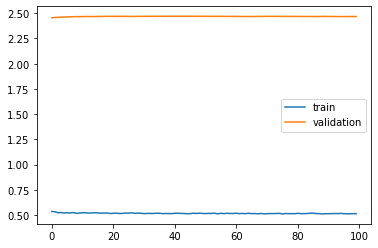

In [84]:

fig1 = plt.figure()
ax1 = fig1.add_subplot(1,1,1)
ax1.plot(history.history['loss'], label='train')
ax1.plot(history.history['val_loss'], label='validation')
ax1.legend();

In [85]:
test = pd.read_csv('datasets/delta/sdn_train_mininet_normalized_test.csv', delimiter=",")     
X_test,Y_test = create_dataset(test, test.delay)

modeling to keras  99.92 %  34.31666666666667  seconds


# predicting

In [86]:
y_pred = model.predict(X_test)

# unormalizing

In [87]:
y_test_inv, y_pred_inv = unormalizing(test, Y_test, y_pred)

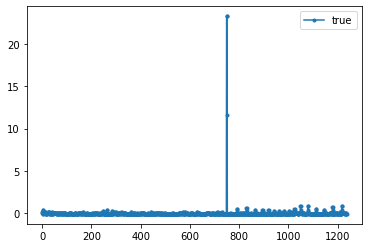

In [88]:
fig2 = plt.figure()
a2 = fig2.add_subplot(1,1,1)
a2.plot(y_test_inv.flatten(), marker='.', label='true')
a2.legend();

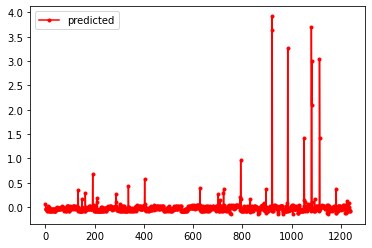

In [89]:
fig3 = plt.figure()
a3 = fig3.add_subplot(1,1,1)
a3.plot(y_pred_inv.flatten(),'r',marker='.', label='predicted')
a3.legend();

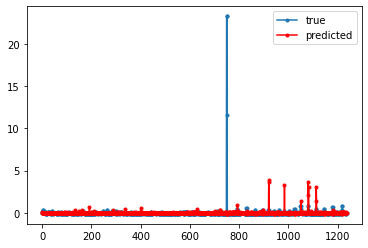

In [90]:
fig4 = plt.figure()
a4 = fig4.add_subplot(1,1,1)

a4.plot(y_test_inv.flatten(), marker='.', label='true')
a4.plot(y_pred_inv.flatten(),'r',marker='.', label='predicted')
a4.legend();

In [91]:
l1 = []
l2 = []
for i in np.arange(y_pred_inv.shape[0]):
    clear_output(wait=True)
    print('progress ',round((i/y_pred_inv.shape[0])*100,2), ('%'))
    if(y_pred_inv[i,0]<=10):
        l1.append(y_pred_inv[i,0])
    if(y_test_inv[0,i]<=10):
        l2.append(y_test_inv[0,i])

y_pred_inv2 = np.array(l1)
y_test_inv2 = np.array(l2)

progress  99.92 %


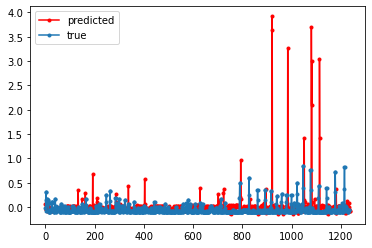

In [92]:
plt.plot(y_pred_inv2.flatten(),'r',marker='.', label='predicted')
plt.plot(y_test_inv2.flatten(), marker='.', label='true')
plt.legend();

In [93]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error

In [94]:
size = np.min([y_pred_inv2.shape[0],y_test_inv2.shape[0] ])
rmse =  mean_squared_error(y_test_inv2[0:size], y_pred_inv2[0:size], squared=False)
mae =  mean_absolute_error(y_test_inv2[0:size], y_pred_inv2[0:size])
median_mae = median_absolute_error(y_test_inv2[0:size], y_pred_inv2[0:size])


print(rmse)
print(mae)
print(median_mae)

0.2930702920658616
0.10777592896885567
0.067766348546621


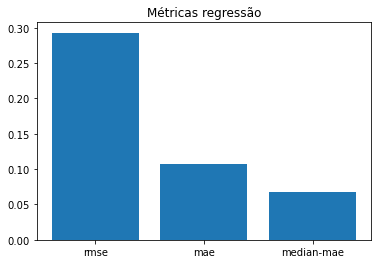

In [95]:
objects = ('rmse', 'mae', 'median-mae')
y_pos = np.arange(3)
performance = [rmse,mae,median_mae]

plt.bar(y_pos, performance, align='center')
plt.xticks(y_pos, objects)
#plt.ylabel('Usage')
plt.title('Métricas regressão')

plt.show()

In [96]:

from sklearn.metrics import explained_variance_score

In [97]:
explained_variance_score(y_test_inv2[0:size], y_pred_inv2[0:size])

-5.37743410171059